In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 14

import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [2]:
import os
def makedir(folder_path):
    # 检查文件夹是否已经存在
    if not os.path.exists(folder_path):
        # 文件夹不存在时创建
        os.makedirs(folder_path)
        print(f"文件夹 '{folder_path}' 已创建")
    else:
        print(f"文件夹 '{folder_path}' 已存在，不进行任何处理")

In [3]:

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    else:
        return intersection / union

In [8]:
# 计算超几何分布pvalue
from scipy.stats import hypergeom
import time
# Fisher's 精确检验
import numpy as np
from scipy.stats import fisher_exact

# core = "peri"
core = "core"
index = "lcczscore"
# index = "lcc_expresssum_zscore"
# index = "lcc_expressmean_zscore"
for per in range(20,100,10):
    trait = 29
    # makedir(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\tissues\%s"%trait)
    results_ct = pd.read_csv(r"E:\00_CeSOP\results\lcczscore-pip-coreperi-alltraits\%s\%s\allcells.csv"%(core,trait))
    results_ct_sorted = results_ct.sort_values(by=index,ascending=False)
    results_ct_sorted_topk = results_ct_sorted.iloc[:int(len(results_ct_sorted) * (per / 100))][[index,"tissue","celltype","cell"]]
    
    #  计算超几何分布pvalue
    topkcells = set(list(results_ct_sorted_topk["cell"]))
    tissuelist = os.listdir(r"E:\00_CeSOP\results\asthma\lcczscore-pip-cell-sixpoints")
    result_index = []
    for tissue in tissuelist:
        tissue_cell = results_ct[results_ct['tissue']==tissue]
        tissue_cell_topk = results_ct_sorted_topk[results_ct_sorted_topk['tissue']==tissue]
        tissue_cellnum = len(tissue_cell)
        tissue_cellnum_topk = len(tissue_cell_topk)
    
        # 计算jaccard系数
        jaccard = jaccard_similarity(set(tissue_cell["cell"]),set(tissue_cell_topk["cell"]))
    
        # 计算fisher精确检验pvalue
        b = tissue_cellnum
        a = tissue_cellnum_topk
        observed_table = [[a, b-a], [np.floor(b/100 * per), b - np.floor(b/100 * per)]]  # 2x2 列联表数据
        odds_ratio, p_value = fisher_exact(observed_table, alternative='greater')
    
        # 所有细胞M中与性状相关的细胞有N个，那么某个组织的n个细胞中有k个性状相关细胞是否显著高
        M = len(results_ct_sorted)
        N = len(results_ct_sorted_topk)
        n = tissue_cellnum
        k = tissue_cellnum_topk
        Hpvalue = hypergeom.sf(k-1,M,N,n)
    
        result_index.append([tissue,tissue_cellnum,tissue_cellnum_topk,
                       jaccard,p_value,Hpvalue])
    
    result_index_df = pd.DataFrame(result_index)
    result_index_df.columns = ["tissue","cellnum","relatedCellnum","jaccard","fisher's pvalue","hypergeom pvalue"]
    print(per,time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    result_index_df.to_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(per,trait,core))


20 2024-11-30 21:39:48
30 2024-11-30 21:39:51
40 2024-11-30 21:39:54
50 2024-11-30 21:39:56
60 2024-11-30 21:40:00
70 2024-11-30 21:40:03
80 2024-11-30 21:40:06
90 2024-11-30 21:40:10


In [9]:
## 细胞类型
# core = "peri"
core = "core"
index = "lcczscore"
# index = "lcc_expresssum_zscore"
# index = "lcc_expressmean_zscore"
trait = 29
results_ct = pd.read_csv(r"E:\00_CeSOP\results\lcczscore-pip-coreperi-alltraits\%s\%s\allcells.csv"%(core,trait))    
results_ct_sorted = results_ct.sort_values(by=index,ascending=False)
    
for per in range(10,100,10):
    # makedir(r"E:\00_CeSOP\results\trait-cells-in-tissues-and-celltypes\celltypes\%s"%trait)
    results_ct_sorted_topk = results_ct_sorted.iloc[:int(len(results_ct_sorted) * (per / 100))][[index,"tissue","celltype","cell"]]
    
    #  计算超几何分布pvalue
    topkcells = set(list(results_ct_sorted_topk["cell"]))
    results_ct_group = results_ct.groupby(["tissue","celltype"])
    result_index = []
    
    for index0, group in results_ct_group:
        tissue_cell = results_ct[(results_ct['tissue']==index0[0]) & (results_ct['celltype']==index0[1])]
        tissue_cell_topk = results_ct_sorted_topk[(results_ct_sorted_topk['tissue']==index0[0])  & (results_ct_sorted_topk['celltype']==index0[1])]
        tissue_cellnum = len(tissue_cell)
        tissue_cellnum_topk = len(tissue_cell_topk)
        
        # 计算jaccard系数
        jaccard = jaccard_similarity(set(tissue_cell["cell"]),set(tissue_cell_topk["cell"]))
    
        # 计算fisher精确检验pvalue
        b = tissue_cellnum
        a = tissue_cellnum_topk
        observed_table = [[a, b-a], [np.floor(b/100 * per), b - np.floor(b/100 * per)]]  # 2x2 列联表数据
        odds_ratio, p_value = fisher_exact(observed_table, alternative='greater')
    
        # 所有细胞M中与性状相关的细胞有N个，那么某个组织的n个细胞中有k个性状相关细胞是否显著高
        M = len(results_ct_sorted)
        N = len(results_ct_sorted_topk)
        n = tissue_cellnum
        k = tissue_cellnum_topk
        Hpvalue = hypergeom.sf(k-1,M,N,n)
    
        result_index.append([index0[0],index0[1],tissue_cellnum,tissue_cellnum_topk,
                       jaccard,p_value,Hpvalue])
    
    result_index_df = pd.DataFrame(result_index)
    result_index_df.columns = ["tissue","celltype","cellnum","relatedCellnum","jaccard","fisher's pvalue","hypergeom pvalue"]
    print(per,time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    result_index_df.to_csv(r"E:\00_CeSOP\results\robust\topk\celltype\top%s_trait%s_%s_lcczscore.csv"%(per,trait,core))

10 2024-11-30 21:44:39
20 2024-11-30 21:45:26
30 2024-11-30 21:46:18
40 2024-11-30 21:46:55
50 2024-11-30 21:47:34
60 2024-11-30 21:48:14
70 2024-11-30 21:49:09
80 2024-11-30 21:49:50
90 2024-11-30 21:50:42


## 鲁棒性评价

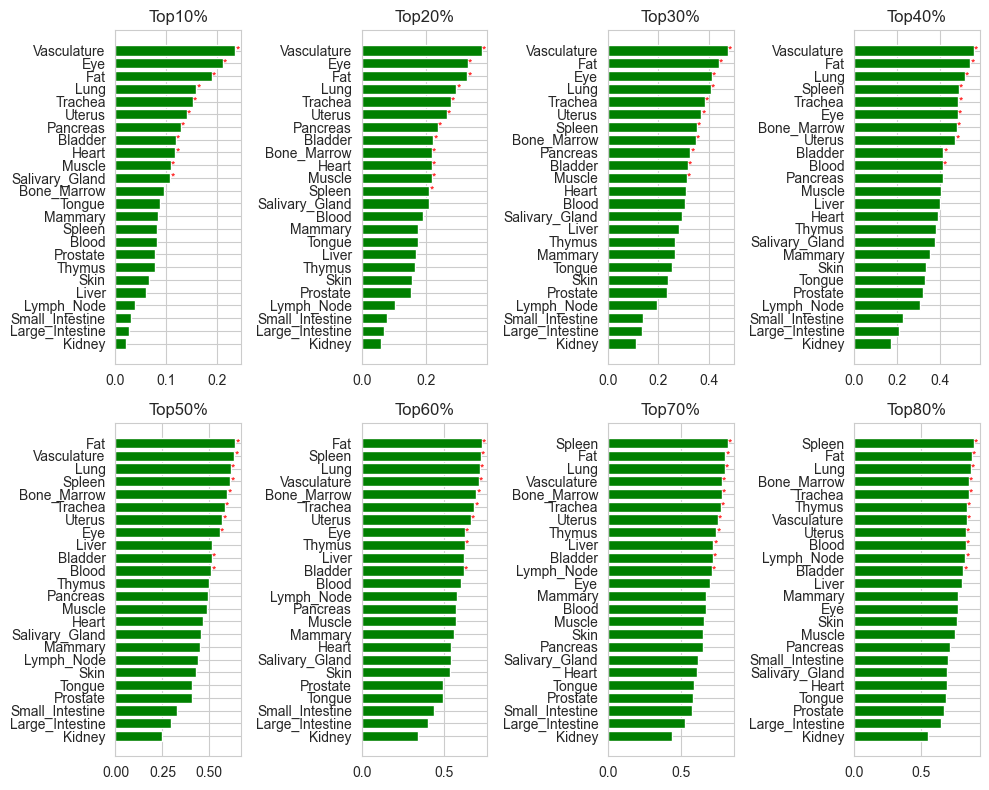

In [22]:
import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 10
# 创建2行5列的子图
fig, axes = plt.subplots(2, 4, figsize=(10, 8))

# 遍历子图并绘制内容
for i, ax in enumerate(axes.flat):
    df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%((i+1)*10,trait,core))
    df2 = df.sort_values(by = "jaccard")
    # plt.figure(figsize=(2,6))
    
    ax.barh(df2["tissue"], df2["jaccard"],color = "green")
    # 添加星号
    for j, value in enumerate(list(df2["jaccard"])):
        if df2[df2["jaccard"]==value]["fisher's pvalue"].values[0] < 0.005:
            ax.text(value, j, "*", color='red', fontsize=8, va='center')
    # ax.plot([0, 1], [i, i+1])  # 示例：绘制简单的线性图
    ax.set_title("Top" + str((i+1)*10) + "%")

# 自动调整布局，避免标签重叠
plt.tight_layout()
# 显示图形
plt.show()


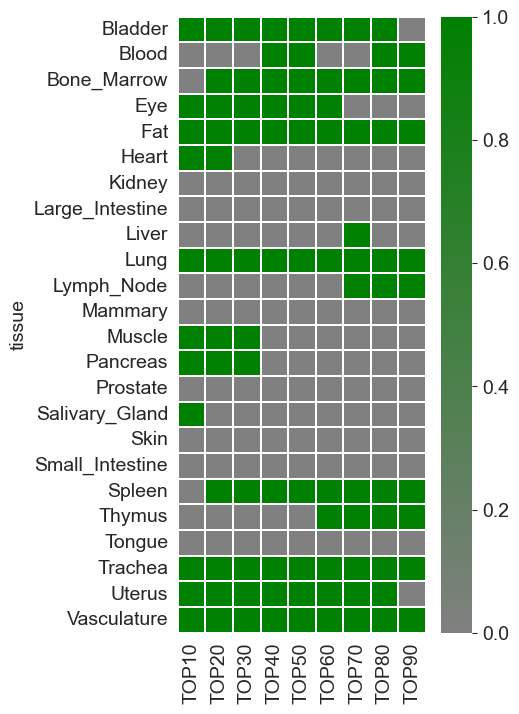

In [100]:
## 性状显著相关的组织or细胞类型数量
fisher_df = pd.DataFrame()
for per in range(10,100,10):
    df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(per,trait,core))
    fisher_df = pd.concat([fisher_df,df["fisher's pvalue"]],axis=1)
    
df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(10,trait,core))    
fisher_df.columns = [f"TOP{i}" for i in range(10, 100, 10)]
fisher_df.index = df["tissue"]

# 将小于 0.005 的值设为 1【表示显著相关】，否则设为 0
fisher_df_01 = (fisher_df < 0.005).astype(int)

# # 使用 seaborn 绘制热图
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# 创建灰色到绿色的自定义颜色映射
colors = [(0, "gray"), (1, "green")]  # (位置, 颜色)，从灰色到绿色
cmap = LinearSegmentedColormap.from_list("gray_green", colors)
plt.figure(figsize=(4, 8))  # 设置图形大小
g = sns.heatmap(fisher_df_01, cmap=cmap,linewidths = 0.05)

# ## 计算每一列中值为 1 的数量
# count_ones = (fisher_df_01 == 1).sum()
# # 可视化：绘制柱状图
# plt.figure(figsize=(2, 4))
# ax = count_ones.plot(kind='barh', color='skyblue',fontsize=12)
# plt.title('#Tissue')
# 
# 
# ## 对于asthma，topk的k取不同值时，得到的性状显著相关的细胞类型和组织基本一致
# ## 指标：jaccard系数 （以top10%作为基准）
# # 1. 提取每一列值为 0 的行列表
# zero_rows = {col: fisher_df_01[fisher_df_01[col] == 0].index.tolist() for col in fisher_df_01.columns}
# 
# # 2. 计算各列的 Jaccard 系数与第一列的 Jaccard 系数
# def jaccard_similarity(list1, list2):
#     set1, set2 = set(list1), set(list2)
#     intersection = len(set1 & set2)
#     union = len(set1 | set2)
#     return intersection / union if union != 0 else 0  # 避免除以0
# 
# # 提取第一列的行列表
# first_column_rows = fisher_df_01['TOP10'].tolist()
# 
# # 计算 zero_rows 之间的 Jaccard 系数
# jaccard_scores_zero_rows = {}
# 
# # 比较每两列之间的 Jaccard 系数
# columns = list(zero_rows.keys())
# for i in range(len(columns)):
#     for j in range(i + 1, len(columns)):
#         col1, col2 = columns[i], columns[j]
#         set1, set2 = set(zero_rows[col1]), set(zero_rows[col2])
#         score = jaccard_similarity(set1, set2)
#         jaccard_scores_zero_rows[(col1, col2)] = score
# 
# # 将结果转换为 DataFrame
# jaccard_matrix1 = pd.DataFrame(index=columns, columns=columns)
# 
# # 填充矩阵
# for (col1, col2), score in jaccard_scores_zero_rows.items():
#     jaccard_matrix1.loc[col1, col2] = score
#     jaccard_matrix1.loc[col2, col1] = score  # 因为 Jaccard 相似度是对称的
#     
#    # 转换数据类型为 float
# jaccard_matrix1 = jaccard_matrix1.apply(pd.to_numeric, errors='coerce')  # 将非数值的部分转为 NaN 
# # 如果需要，可以填充缺失值（NaN）
# jaccard_matrix1.fillna(1, inplace=True)
# # 输出结果
# print("Jaccard similarity matrix between zero rows:")
# print(jaccard_matrix1)
# 
# # 使用 seaborn 绘制热图
# import seaborn as sns
# from matplotlib.colors import LinearSegmentedColormap
# # 创建灰色到绿色的自定义颜色映射
# # colors = [(0, "gray"), (1, "green")]  # (位置, 颜色)，从灰色到绿色
# # cmap = LinearSegmentedColormap.from_list("gray_green", colors)
# plt.figure(figsize=(4, 4))  # 设置图形大小
# sns.heatmap(jaccard_matrix1, cmap="Blues",linewidths = 0.05)
# plt.title("Jaccard of Tissue")

Jaccard similarity matrix between zero rows:
          TOP10     TOP20     TOP30     TOP40     TOP50     TOP60     TOP70  \
TOP10  1.000000  0.960199  0.911548  0.878345  0.846154  0.806147  0.753521   
TOP20  0.960199  1.000000  0.943878  0.909091  0.870647  0.824390  0.769976   
TOP30  0.911548  0.943878  1.000000  0.947781  0.912371  0.863636  0.807018   
TOP40  0.878345  0.909091  0.947781  1.000000  0.957447  0.896373  0.842784   
TOP50  0.846154  0.870647  0.912371  0.957447  1.000000  0.931034  0.880952   
TOP60  0.806147  0.824390  0.863636  0.896373  0.931034  1.000000  0.931694   
TOP70  0.753521  0.769976  0.807018  0.842784  0.880952  0.931694  1.000000   
TOP80  0.712297  0.723150  0.758025  0.791878  0.823377  0.876344  0.929178   
TOP90  0.700224  0.706422  0.723005  0.745803  0.765854  0.809045  0.840314   

          TOP80     TOP90  
TOP10  0.712297  0.700224  
TOP20  0.723150  0.706422  
TOP30  0.758025  0.723005  
TOP40  0.791878  0.745803  
TOP50  0.823377  0.76585

Text(0.5, 1.0, 'Jaccard of Celltype')

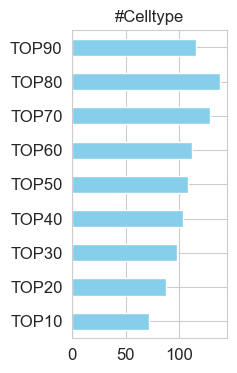

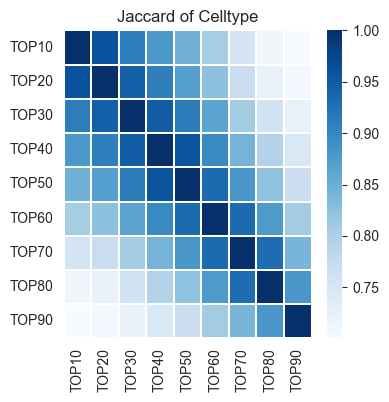

In [96]:
## 性状显著相关的组织or细胞类型数量
fisher_df = pd.DataFrame()
for per in range(10,100,10):
    df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\celltype\top%s_trait%s_%s_lcczscore.csv"%(per,trait,core))
    fisher_df = pd.concat([fisher_df,df["fisher's pvalue"]],axis=1)
    
df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\celltype\top%s_trait%s_%s_lcczscore.csv"%(10,trait,core))    
fisher_df.columns = [f"TOP{i}" for i in range(10, 100, 10)]
fisher_df.index = df["tissue"]  + "_" + df["celltype"]
# fisher_df = fisher_df.T
# 将小于 0.005 的值设为 1【表示显著相关】，否则设为 0
fisher_df_01 = (fisher_df < 0.005).astype(int)

# # 使用 seaborn 绘制热图
# import seaborn as sns
# from matplotlib.colors import LinearSegmentedColormap
# # 创建灰色到绿色的自定义颜色映射
# colors = [(0, "gray"), (1, "green")]  # (位置, 颜色)，从灰色到绿色
# cmap = LinearSegmentedColormap.from_list("gray_green", colors)
# 
# plt.figure(figsize=(15, 6))  # 设置图形大小
# sns.heatmap(fisher_df_01, cmap=cmap)

## 计算每一列中值为 1 的数量
count_ones = (fisher_df_01 == 1).sum()
# 可视化：绘制柱状图
plt.figure(figsize=(2, 4))
ax = count_ones.plot(kind='barh', color='skyblue',fontsize=12)
plt.title('#Celltype')
# 在每个柱子上显示数值
# for i, v in enumerate(count_ones):
    # ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)
    
    ## 指标：jaccard系数 （以top10%作为基准）
# 1. 提取每一列值为 0 的行列表
zero_rows = {col: fisher_df_01[fisher_df_01[col] == 0].index.tolist() for col in fisher_df_01.columns}

# 2. 计算各列的 Jaccard 系数与第一列的 Jaccard 系数
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0  # 避免除以0

# 提取第一列的行列表
first_column_rows = fisher_df_01['TOP10'].tolist()

# 计算 zero_rows 之间的 Jaccard 系数
jaccard_scores_zero_rows = {}

# 比较每两列之间的 Jaccard 系数
columns = list(zero_rows.keys())
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1, col2 = columns[i], columns[j]
        set1, set2 = set(zero_rows[col1]), set(zero_rows[col2])
        score = jaccard_similarity(set1, set2)
        jaccard_scores_zero_rows[(col1, col2)] = score

# 将结果转换为 DataFrame
jaccard_matrix2 = pd.DataFrame(index=columns, columns=columns)

# 填充矩阵
for (col1, col2), score in jaccard_scores_zero_rows.items():
    jaccard_matrix2.loc[col1, col2] = score
    jaccard_matrix2.loc[col2, col1] = score  # 因为 Jaccard 相似度是对称的
    
   # 转换数据类型为 float
jaccard_matrix2 = jaccard_matrix2.apply(pd.to_numeric, errors='coerce')  # 将非数值的部分转为 NaN 
# 如果需要，可以填充缺失值（NaN）
jaccard_matrix2.fillna(1, inplace=True)
# 输出结果
print("Jaccard similarity matrix between zero rows:")
print(jaccard_matrix2)

# 使用 seaborn 绘制热图
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# 创建灰色到绿色的自定义颜色映射
# colors = [(0, "gray"), (1, "green")]  # (位置, 颜色)，从灰色到绿色
# cmap = LinearSegmentedColormap.from_list("gray_green", colors)
plt.figure(figsize=(4, 4))  # 设置图形大小
sns.heatmap(jaccard_matrix2, cmap="Blues",linewidths = 0.05)
plt.title("Jaccard of Celltype")

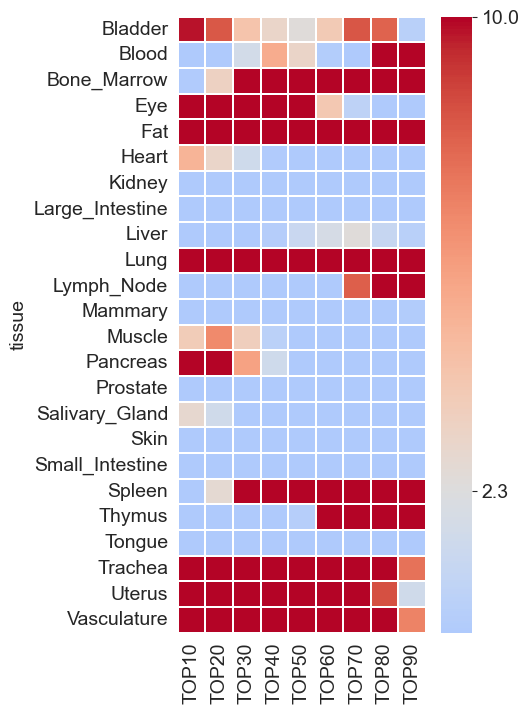

In [61]:
## 性状显著相关的组织or细胞类型数量
epsilon = 1e-10
trait = 29
core = "core"
fisher_df = pd.DataFrame()
for per in range(10,100,10):
    df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(per,trait,core))
    df["log fisher's pvalue"] = -np.log10(df["fisher's pvalue"] + epsilon)
    fisher_df = pd.concat([fisher_df,df["log fisher's pvalue"]],axis=1)
    
df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(10,trait,core))    
fisher_df.columns = [f"TOP{i}" for i in range(10, 100, 10)]
fisher_df.index = df["tissue"]
# fisher_df = fisher_df.T
# 将小于 0.005 的值设为 1【表示显著相关】，否则设为 0
# fisher_df_01 = (fisher_df < 0.005).astype(int)

# 使用 seaborn 绘制热图
import seaborn as sns
import math
plt.rcParams['font.size'] = 14
plt.figure(figsize=(4, 8))  # 设置图形大小
x = -np.log10(0.005 + epsilon)
g = sns.heatmap(fisher_df, cmap='coolwarm', linewidths = 0.05, 
                center = -np.log10(0.005 + epsilon),
                cbar_kws={
                # 'orientation': 'horizontal',  # 色条的方向为水平
                'shrink': 1,                # 色条缩小为 80%
                'aspect': 20,                 # 色条的长宽比
                # 'label': 'Value',             # 色条标签
                'ticks': [math.floor(fisher_df.values.min()), -np.log10(0.005 + epsilon), math.ceil(fisher_df.values.max())]           # 设置色条的刻度
            }
                )

<Figure size 400x100 with 0 Axes>

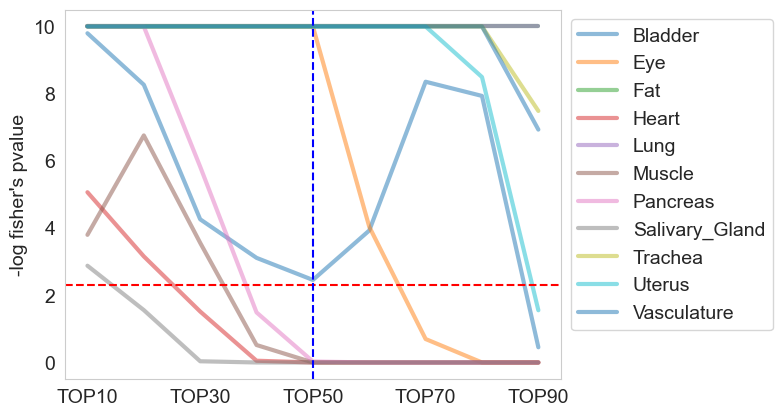

In [51]:
df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(10,trait,core),index_col=0) 
# 筛选 col1 列值小于 0.005 的行
filtered_list = list(df[df["fisher's pvalue"] < 0.005]["tissue"])
fisher_df = pd.DataFrame()
for per in range(10,100,10):
    df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(per,trait,core))
    # 筛选 col1 列的值在 value_list 中的行
    filtered_df = df[df['tissue'].isin(filtered_list)]
    filtered_df["log fisher's pvalue"] = -np.log10(filtered_df["fisher's pvalue"] + epsilon)
    fisher_df = pd.concat([fisher_df,filtered_df["log fisher's pvalue"]],axis=1)
fisher_df.index = filtered_list
fisher_df.columns = [f"TOP{i}" for i in range(10, 100, 10)]

import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 14
plt.figure(figsize=(4, 1))
ax = fisher_df.T.plot(linestyle='-', linewidth=3,alpha=0.5,ylabel="-log fisher's pvalue")
plt.grid(False)
# 显示图形
# 设置图例在图表外部
# 添加横线
plt.axhline(y=-np.log10(0.005 + epsilon), color='red', linestyle='--')

# 添加竖线
plt.axvline(x=4, color='blue', linestyle='--')

# 显示图例
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

<Figure size 400x100 with 0 Axes>

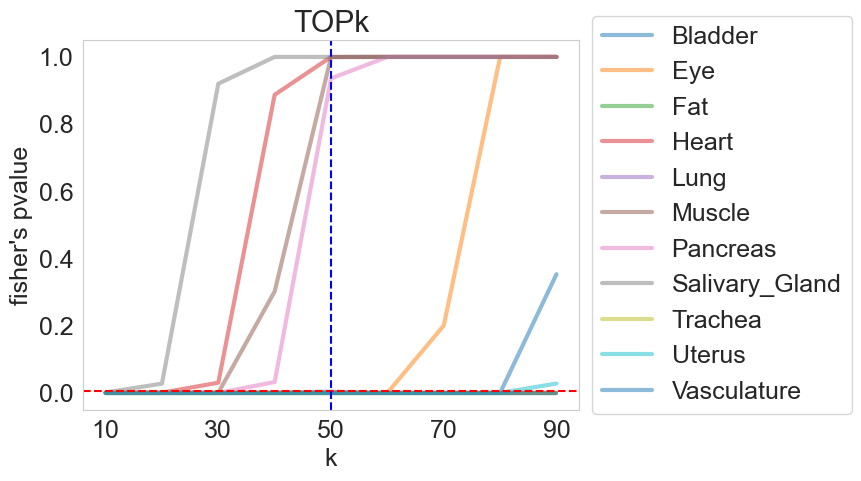

In [59]:
df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(10,trait,core),index_col=0) 
# 筛选 col1 列值小于 0.005 的行
filtered_list = list(df[df["fisher's pvalue"] < 0.005]["tissue"])
fisher_df = pd.DataFrame()
for per in range(10,100,10):
    df = pd.read_csv(r"E:\00_CeSOP\results\robust\topk\tissue\top%s_trait%s_%s_lcczscore.csv"%(per,trait,core))
    # 筛选 col1 列的值在 value_list 中的行
    filtered_df = df[df['tissue'].isin(filtered_list)]
    # filtered_df["log fisher's pvalue"] = -np.log10(filtered_df["fisher's pvalue"] + epsilon)
    fisher_df = pd.concat([fisher_df,filtered_df["fisher's pvalue"]],axis=1)
fisher_df.index = filtered_list
# fisher_df.columns = [f"TOP{i}" for i in range(10, 100, 10)]
fisher_df.columns = [f"{i}" for i in range(10, 100, 10)]

plt.rcParams['font.size'] = 18
plt.figure(figsize=(4, 1))
ax = fisher_df.T.plot(title = "TOPk",linestyle='-', linewidth=3,alpha=0.5,ylabel="fisher's pvalue",xlabel = "k")
plt.grid(False)
# 显示图形
# 设置图例在图表外部
# 添加横线
plt.axhline(y=0.005, color='red', linestyle='--')
# 添加竖线
plt.axvline(x=4, color='blue', linestyle='--')
# 显示图例
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.1))